# 06 Eye-Tracking Event Analysis

## Overview
This notebook analyzes **eye-tracking data** from SR Research EyeLink recordings, synchronizing gaze behavior with experimental events.

**Purpose:**
- Load and parse EyeLink EDF files containing gaze coordinates and pupil size measurements
- Synchronize eye-tracking timestamps with experimental stimulus presentation (AI_Response.started events)
- Extract eye-tracking features for each trial to analyze reading behavior and cognitive load

**What it does:**
1. Loads session mapping (from Notebook 01) to identify which sessions have eye-tracking data
2. For each matched session:
   - Parses the corresponding EDF file to extract gaze position (X, Y coordinates) and pupil sizes
   - Synchronizes eye-tracking timestamps with experiment event timestamps
   - Segments eye-tracking data by trial based on AI_Response.started markers
   - Validates gaze positions within the defined Region of Interest (ROI) for text stimuli
3. Computes eye-tracking features per trial:
   - **Fixations:** duration, count, spatial dispersion, time to first fixation
   - **Saccades:** amplitude, duration, frequency
   - **Pupil metrics:** mean size, Index of Pupillary Activity (IPA)
4. Saves extracted features for statistical analysis

**Output:**
- `session_00-eye-features.pkl`, `session_01-eye-features.pkl`, etc.
- Each file contains trial-level eye-tracking features ready for analysis

**Next step:** Use features to analyze differences across alignment conditions or correlate with EEG/behavioral measures.

**Code Attribution:**
- Original eye-tracking analysis code adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). MobileHCI 2024 Papers - Submission 7226.
- OSF Repository: https://osf.io/fncj4/overview (Created: Sep 11, 2023)
- License: GNU General Public License (GPL) 3.0
- Code has been modified and extended for session-based processing and alignment with EEG data.

**Note:** This notebook requires preprocessing of EDF files to ASC format using SR Research tools (edf2asc).

## 1. Import Libraries and Setup

In [ ]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from tqdm.auto import tqdm

c:\Users\kimbe\iCloudDrive\Master\Masterarbeit\Analyse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## 2. Load Session Mapping

# Load session mapping for eye-tracking data
df_sessions = pd.read_csv('./session_mapping.csv')

# Filter sessions with EEG match (eye-tracking available)
df_matched = df_sessions[df_sessions['eeg_file'] != 'NO MATCH'].copy()

# Extract session IDs
session_ids = df_matched.index.tolist()
print(f'Available sessions: {session_ids}')
print(f'Number of sessions: {len(session_ids)}')

# Show session info
print('\nSession details:')
print(df_matched[['experiment_file', 'n_trials', 'coverage']])

Available sessions: [0, 1, 4]
Number of sessions: 3

Session details:
                                     experiment_file  n_trials coverage
0  01_human-llm-alignment_2025-11-17_11h36.44.912...        50    60.3%
1  01_human-llm-alignment_2025-11-20_13h16.37.791...        39    79.3%
4  01_human-llm-alignment_2025-11-24_14h13.05.529...        49    54.7%


In [5]:
# Region of Interest (ROI) for text stimulus
# TODO: Adjust to actual stimulus coordinates!
x1 = 585
y1 = 165.0

x2 = 1335
y2 = 915.0

roi_width = x2 - x1
roi_height = y2 - y1
print(f'ROI size: {roi_width} x {roi_height} pixels')
print(f'ROI coordinates: ({x1}, {y1}) to ({x2}, {y2})')

ROI size: 750 x 750.0 pixels
ROI coordinates: (585, 165.0) to (1335, 915.0)


## 4. Load ASC Files (Converted Eye-Tracking Data)

In [12]:
# Check available ASC files (converted from EDF)
asc_files = list(Path('./asc_files').glob('*.asc'))
asc_files = [f for f in asc_files if 'copy' not in f.name]  # Skip duplicates

print(f'Found {len(asc_files)} ASC files:')
for asc in sorted(asc_files):
    size_mb = asc.stat().st_size / (1024 * 1024)
    print(f'  {asc.name:40s} ({size_mb:.1f} MB)')

# Map ASC files to sessions manually based on timestamp inspection
print('\nExperiment files:')
for idx, row in df_matched.iterrows():
    exp_file = row['experiment_file']
    exp_date = row['experiment_date']
    print(f"Session {idx}: {exp_file}")
    print(f"  Date: {exp_date}")

print('\nManual mapping:')
session_asc_map = {
    0: Path('./asc_files/tb171106_2025_11_17_11_36.asc'),   # 2025-11-17 11:36
    1: Path('./asc_files/201101_2025_11_20_13_16.asc'),     # 2025-11-20 13:16
    4: Path('./asc_files/241101_2025_11_24_14_13.asc')      # 2025-11-24 14:13
}

for session_id, asc_path in session_asc_map.items():
    if asc_path.exists():
        print(f"✓ Session {session_id}: {asc_path.name}")
    else:
        print(f"✗ Session {session_id}: {asc_path.name} NOT FOUND")

print(f'\nMatched {len(session_asc_map)}/{len(df_matched)} sessions')

Found 8 ASC files:
  201101_2025_11_20_13_16.asc              (139.9 MB)
  201102_2025_11_20_15_02.asc              (132.8 MB)
  201105_2025_11_20_16_25.asc              (114.1 MB)
  241101_2025_11_24_14_13.asc              (174.8 MB)
  271103_2025_11_27_10_49.asc              (83.6 MB)
  271105_2025_11_27_12_50.asc              (117.1 MB)
  2711ih_2025_11_27_11_29.asc              (87.0 MB)
  tb171106_2025_11_17_11_36.asc            (103.7 MB)

Experiment files:
Session 0: 01_human-llm-alignment_2025-11-17_11h36.44.912.csv
  Date: 2025-11-17 11:38:44
Session 1: 01_human-llm-alignment_2025-11-20_13h16.37.791.csv
  Date: 2025-11-20 13:17:08
Session 4: 01_human-llm-alignment_2025-11-24_14h13.05.529.csv
  Date: 2025-11-24 14:15:13

Manual mapping:
✓ Session 0: tb171106_2025_11_17_11_36.asc
✓ Session 1: 201101_2025_11_20_13_16.asc
✓ Session 4: 241101_2025_11_24_14_13.asc

Matched 3/3 sessions


## 5. Parse ASC File (Eye-Tracking Samples)

In [7]:
def parse_asc_file(asc_path):
    """
    Parse SR Research EyeLink ASC file.
    
    Returns:
    - samples_df: DataFrame with timestamp, x_left, y_left, pupil_left, x_right, y_right, pupil_right
    - events: List of event dictionaries
    - messages: List of message dictionaries
    """
    samples = []
    events = []
    messages = []
    
    print(f'Parsing {asc_path.name}...')
    
    with open(asc_path, 'r', encoding='latin-1') as f:
        for line_num, line in enumerate(f):
            if line_num % 1000000 == 0 and line_num > 0:
                print(f'  Read {line_num:,} lines...')
            
            parts = line.split()
            if not parts:
                continue
            
            # Sample data: timestamp x_left y_left pupil_left x_right y_right pupil_right
            if parts[0].isdigit():
                try:
                    timestamp = float(parts[0]) / 1000  # Convert ms to seconds
                    
                    # Parse left eye (binocular recording)
                    x_left = float(parts[1]) if parts[1] != '.' else np.nan
                    y_left = float(parts[2]) if parts[2] != '.' else np.nan
                    pupil_left = float(parts[3]) if parts[3] != '.' else np.nan
                    
                    # Parse right eye
                    x_right = float(parts[4]) if len(parts) > 4 and parts[4] != '.' else np.nan
                    y_right = float(parts[5]) if len(parts) > 5 and parts[5] != '.' else np.nan
                    pupil_right = float(parts[6]) if len(parts) > 6 and parts[6] != '.' else np.nan
                    
                    samples.append({
                        'timestamp': timestamp,
                        'x_left': x_left,
                        'y_left': y_left,
                        'pupil_left': pupil_left,
                        'x_right': x_right,
                        'y_right': y_right,
                        'pupil_right': pupil_right
                    })
                except (ValueError, IndexError):
                    continue
            
            # Events (fixations, saccades, blinks)
            elif line.startswith('EFIX') or line.startswith('ESACC') or line.startswith('EBLINK'):
                events.append(line.strip())
            
            # Messages (experiment markers)
            elif line.startswith('MSG'):
                messages.append(line.strip())
    
    samples_df = pd.DataFrame(samples)
    print(f'Loaded {len(samples_df):,} samples')
    print(f'Duration: {samples_df["timestamp"].max() - samples_df["timestamp"].min():.1f} seconds')
    print(f'Events: {len(events)}, Messages: {len(messages)}')
    
    return samples_df, events, messages

In [13]:
# Test with Session 0
if 0 in session_asc_map:
    test_asc = session_asc_map[0]
    samples_df, events, messages = parse_asc_file(test_asc)
    
    # Display first few samples
    print('\nFirst 5 samples:')
    print(samples_df.head())
    
    print('\nData summary:')
    print(samples_df.describe())
else:
    print('Session 0 not found in ASC files')

Parsing tb171106_2025_11_17_11_36.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0

First 5 samples:
   timestamp  x_left  y_left  pupil_left  x_right  y_right  pupil_right
0   2125.299   958.2   523.8       821.0    965.0    542.4        747.0
1   2125.300   961.7   525.3       822.0    964.9    538.6        745.0
2   2125.301   960.6   525.9       821.0    962.9    534.8        746.0
3   2125.302   959.8   527.2       819.0    960.9    534.9        747.0
4   2125.303   959.6   533.8       825.0    960.1    534.8        750.0

Data summary:

First 5 samples:
   timestamp  x_left  y_left  pupil_left  x_right  y_right  pupil_right
0   2125.299   958.2   523.8       821.0    965.0    542.4        747.0
1   2125.300   961.7   525.3       822.0    964.9    538.6        745.0
2   2125.3

## 5.1 Synchronize Eye-Tracking with Experiment Events

In [20]:
def synchronize_eye_with_experiment(session_id, samples_df, exp_csv_path, df_matched):
    """
    Synchronize eye-tracking data with experiment events.
    
    Parameters:
    - session_id: Session identifier
    - samples_df: Eye-tracking samples DataFrame
    - exp_csv_path: Path to experiment CSV file
    - df_matched: Session mapping DataFrame
    
    Returns:
    - trials_data: List of dictionaries, each containing trial eye-tracking data
    """
    # Load experiment data (PsychoPy CSV with potential encoding issues)
    try:
        exp_df = pd.read_csv(exp_csv_path, encoding='utf-8')
    except:
        exp_df = pd.read_csv(exp_csv_path, encoding='latin-1', on_bad_lines='skip')
    
    # Filter for AI_Response.started events (stimulus onset)
    trials = exp_df[exp_df['AI_Response.started'].notna()].copy()
    trials = trials.reset_index(drop=True)
    
    print(f'Found {len(trials)} trials in experiment data')
    
    # Calculate time offset between experiment and eye-tracking
    # Eye-tracking timestamps are absolute, experiment timestamps are relative
    exp_start = trials.iloc[0]['AI_Response.started']
    eye_start = samples_df['timestamp'].min()
    time_offset = eye_start - exp_start
    
    print(f'Time offset: {time_offset:.1f}s ({time_offset/60:.2f} min)')
    print(f'Expected offset from session_mapping: {df_matched.loc[session_id, "time_offset_min"]:.2f} min')
    
    # Extract trial information
    trials_data = []
    
    for trial_idx, trial_row in trials.iterrows():
        # Get stimulus onset time (experiment time)
        onset_time_exp = trial_row['AI_Response.started']
        
        # Convert to eye-tracking time
        onset_time_eye = onset_time_exp + time_offset
        
        # Find eye-tracking samples for this trial
        # Assume trial duration ~30 seconds (adjust based on your experiment)
        trial_duration = 30.0
        
        # Get samples for this trial window
        trial_samples = samples_df[
            (samples_df['timestamp'] >= onset_time_eye) & 
            (samples_df['timestamp'] < onset_time_eye + trial_duration)
        ].copy()
        
        if len(trial_samples) == 0:
            print(f'  Warning: No eye-tracking data for trial {trial_idx}')
            continue
        
        # Calculate ROI coverage (percentage of samples within ROI)
        in_roi_left = (
            (trial_samples['x_left'] >= x1) & (trial_samples['x_left'] <= x2) &
            (trial_samples['y_left'] >= y1) & (trial_samples['y_left'] <= y2)
        )
        in_roi_right = (
            (trial_samples['x_right'] >= x1) & (trial_samples['x_right'] <= x2) &
            (trial_samples['y_right'] >= y1) & (trial_samples['y_right'] <= y2)
        )
        
        roi_coverage = (in_roi_left | in_roi_right).sum() / len(trial_samples) * 100
        
        # Store trial data
        trial_data = {
            'session_id': session_id,
            'trial_idx': trial_idx,
            'trial_n': trial_row.get('ScenarioLoop.thisN', trial_idx),
            'alignment': trial_row.get('AI_Alignment', 'unknown'),
            'text': trial_row.get('text.text', ''),
            'onset_time': onset_time_eye,
            'duration': len(trial_samples) / 1000.0,  # Convert samples to seconds (1000 Hz)
            'roi_coverage': roi_coverage,
            'samples': trial_samples
        }
        
        trials_data.append(trial_data)
    
    print(f'Synchronized {len(trials_data)} trials')
    if len(trials_data) > 0:
        print(f'Mean ROI coverage: {np.mean([t["roi_coverage"] for t in trials_data]):.1f}%')
        print(f'Mean trial duration: {np.mean([t["duration"] for t in trials_data]):.1f}s')
    
    return trials_data

In [21]:
# Test synchronization with Session 0
session_id = 0
exp_csv = Path('./Data') / df_matched.loc[session_id, 'experiment_file']

print(f'Experiment CSV: {exp_csv.name}')
print(f'Eye-tracking samples: {len(samples_df):,}')

trials_data = synchronize_eye_with_experiment(session_id, samples_df, exp_csv, df_matched)

# Show first trial info
if len(trials_data) > 0:
    print(f'\nFirst trial details:')
    print(f'  Trial index: {trials_data[0]["trial_idx"]}')
    print(f'  Alignment: {trials_data[0]["alignment"]}')
    print(f'  Duration: {trials_data[0]["duration"]:.1f}s')
    print(f'  ROI coverage: {trials_data[0]["roi_coverage"]:.1f}%')
    print(f'  Samples: {len(trials_data[0]["samples"]):,}')
else:
    print('\nNo trials synchronized successfully!')

Experiment CSV: 01_human-llm-alignment_2025-11-17_11h36.44.912.csv
Eye-tracking samples: 2,047,168
Found 13 trials in experiment data
Time offset: 1734.0s (28.90 min)
Expected offset from session_mapping: 38.78 min
Synchronized 13 trials
Mean ROI coverage: 92.3%
Mean trial duration: 30.0s

First trial details:
  Trial index: 0
  Alignment: unknown
  Duration: 30.0s
  ROI coverage: 95.3%
  Samples: 30,000
Synchronized 13 trials
Mean ROI coverage: 92.3%
Mean trial duration: 30.0s

First trial details:
  Trial index: 0
  Alignment: unknown
  Duration: 30.0s
  ROI coverage: 95.3%
  Samples: 30,000


In [18]:
# Debug: Check timestamp ranges
exp_df = pd.read_csv(exp_csv, encoding='latin-1', on_bad_lines='skip')
trials_exp = exp_df[exp_df['AI_Response.started'].notna()]

print('Experiment timestamps (first 3 trials):')
for i in range(min(3, len(trials_exp))):
    print(f'  Trial {i}: {trials_exp.iloc[i]["AI_Response.started"]:.3f}')

print(f'\nEye-tracking timestamp range:')
print(f'  Min: {samples_df["timestamp"].min():.3f}')
print(f'  Max: {samples_df["timestamp"].max():.3f}')

print(f'\nTimestamp difference (should be small if synchronized):')
first_trial_time = trials_exp.iloc[0]['AI_Response.started']
eye_start_time = samples_df['timestamp'].min()
print(f'  Experiment start: {first_trial_time:.3f}')
print(f'  Eye-tracking start: {eye_start_time:.3f}')
print(f'  Difference: {abs(first_trial_time - eye_start_time):.3f} seconds')

Experiment timestamps (first 3 trials):
  Trial 0: 391.338
  Trial 1: 622.127
  Trial 2: 883.295

Eye-tracking timestamp range:
  Min: 2125.299
  Max: 4172.466

Timestamp difference (should be small if synchronized):
  Experiment start: 391.338
  Eye-tracking start: 2125.299
  Difference: 1733.961 seconds


In [19]:
# Check if there are messages in the ASC file that could help with synchronization
print(f'Number of messages in ASC file: {len(messages)}')
if len(messages) > 0:
    print('\nFirst 10 messages:')
    for msg in messages[:10]:
        print(f'  {msg}')
else:
    print('\nNo messages found in ASC file.')
    print('We need to use time offset from session_mapping.csv')
    
    # Get time offset from session mapping
    time_offset_min = df_matched.loc[session_id, 'time_offset_min']
    print(f'\nTime offset from session_mapping: {time_offset_min:.2f} minutes ({time_offset_min*60:.1f} seconds)')
    
    # Calculate offset
    exp_start = trials_exp.iloc[0]['AI_Response.started']
    eye_start = samples_df['timestamp'].min()
    calculated_offset = eye_start - exp_start
    
    print(f'\nCalculated offset: {calculated_offset:.1f} seconds ({calculated_offset/60:.2f} minutes)')
    print(f'This should match the time_offset_min from session_mapping')

Number of messages in ASC file: 0

No messages found in ASC file.
We need to use time offset from session_mapping.csv

Time offset from session_mapping: 38.78 minutes (2326.8 seconds)

Calculated offset: 1734.0 seconds (28.90 minutes)
This should match the time_offset_min from session_mapping


## 5.2 Process All Sessions

In [22]:
def process_all_sessions_eye_tracking(session_asc_map, df_matched):
    """
    Process all sessions: parse ASC files, synchronize with experiment, save preprocessed data.
    
    Parameters:
    - session_asc_map: Dictionary mapping session_id to ASC file path
    - df_matched: Session mapping DataFrame
    
    Returns:
    - all_sessions_data: Dictionary with session_id as key and trials_data as value
    """
    all_sessions_data = {}
    
    for session_id, asc_path in tqdm(session_asc_map.items(), desc='Processing sessions'):
        print(f'\n{"="*60}')
        print(f'Processing Session {session_id}')
        print(f'{"="*60}')
        
        # Parse ASC file
        samples_df, events, messages = parse_asc_file(asc_path)
        
        # Get experiment CSV
        exp_csv = Path('./Data') / df_matched.loc[session_id, 'experiment_file']
        
        # Synchronize with experiment
        trials_data = synchronize_eye_with_experiment(session_id, samples_df, exp_csv, df_matched)
        
        # Save preprocessed data
        output_file = f'./preprocessed/session_{session_id:02d}-eye.pkl'
        pd.to_pickle(trials_data, output_file)
        print(f'\n✓ Saved to {output_file}')
        
        # Store in dictionary
        all_sessions_data[session_id] = trials_data
    
    print(f'\n{"="*60}')
    print('All sessions processed successfully!')
    print(f'{"="*60}')
    
    return all_sessions_data

In [25]:
# Process all 3 sessions
all_sessions_data = process_all_sessions_eye_tracking(session_asc_map, df_matched)

# Summary statistics
print('\nSummary:')
total_trials = sum(len(trials) for trials in all_sessions_data.values())
print(f'Total sessions: {len(all_sessions_data)}')
print(f'Total trials: {total_trials}')

for session_id, trials in all_sessions_data.items():
    mean_roi = np.mean([t['roi_coverage'] for t in trials])
    mean_dur = np.mean([t['duration'] for t in trials])
    print(f'Session {session_id}: {len(trials)} trials, ROI coverage: {mean_roi:.1f}%, Mean duration: {mean_dur:.1f}s')


Processing Session 0
Parsing tb171106_2025_11_17_11_36.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Found 13 trials in experiment data
Time offset: 1734.0s (28.90 min)
Expected offset from session_mapping: 38.78 min
Found 13 trials in experiment data
Time offset: 1734.0s (28.90 min)
Expected offset from session_mapping: 38.78 min


Processing sessions:  33%|███▎      | 1/3 [00:15<00:30, 15.18s/it]

Synchronized 13 trials
Mean ROI coverage: 92.3%
Mean trial duration: 30.0s

✓ Saved to ./preprocessed/session_00-eye.pkl

Processing Session 1
Parsing 201101_2025_11_20_13_16.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,686,472 samples
Duration: 2686.5 seconds
Events: 0, Messages: 0
Loaded 2,686,472 samples
Duration: 2686.5 seconds
Events: 0, Messages: 0
Found 18 trials in experiment data
Time offset: 1727.6s (28.79 min)
Expected offset from session_mapping: 1.46 min
Found 18 trials in experiment data
Time offset: 1727.6s (28.79 min)
Expected offset from session_mapping: 1.46 min


Processing sessions:  67%|██████▋   | 2/3 [00:36<00:18, 18.56s/it]

Synchronized 18 trials
Mean ROI coverage: 34.8%
Mean trial duration: 30.0s

✓ Saved to ./preprocessed/session_01-eye.pkl

Processing Session 4
Parsing 241101_2025_11_24_14_13.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
  Read 3,000,000 lines...
  Read 3,000,000 lines...
Loaded 3,396,914 samples
Duration: 3396.9 seconds
Events: 0, Messages: 0
Loaded 3,396,914 samples
Duration: 3396.9 seconds
Events: 0, Messages: 0
Found 14 trials in experiment data
Time offset: 4940.3s (82.34 min)
Expected offset from session_mapping: -12.95 min
Found 14 trials in experiment data
Time offset: 4940.3s (82.34 min)
Expected offset from session_mapping: -12.95 min


Processing sessions: 100%|██████████| 3/3 [01:03<00:00, 21.18s/it]

Synchronized 14 trials
Mean ROI coverage: 52.4%
Mean trial duration: 30.0s

✓ Saved to ./preprocessed/session_04-eye.pkl

All sessions processed successfully!

Summary:
Total sessions: 3
Total trials: 45
Session 0: 13 trials, ROI coverage: 92.3%, Mean duration: 30.0s
Session 1: 18 trials, ROI coverage: 34.8%, Mean duration: 30.0s
Session 4: 14 trials, ROI coverage: 52.4%, Mean duration: 30.0s


## 6. Feature Extraction

Extract eye-tracking features from synchronized trials for statistical analysis.

In [26]:
def calculate_fixations(samples_df, velocity_threshold=30, min_duration=0.05):
    """
    Calculate fixations using velocity-based algorithm.
    
    Parameters:
    - samples_df: DataFrame with gaze coordinates
    - velocity_threshold: Threshold in degrees/second (default: 30)
    - min_duration: Minimum fixation duration in seconds (default: 50ms)
    
    Returns:
    - fixations: List of fixation dictionaries
    """
    # Use average of both eyes
    x = (samples_df['x_left'] + samples_df['x_right']) / 2
    y = (samples_df['y_left'] + samples_df['y_right']) / 2
    
    # Calculate velocity (pixels per sample, approximate)
    dx = x.diff()
    dy = y.diff()
    velocity = np.sqrt(dx**2 + dy**2) * 1000  # Convert to pixels/second (1000 Hz)
    
    # Identify fixations (velocity below threshold)
    is_fixation = velocity < velocity_threshold
    
    # Find fixation groups
    fixation_groups = (is_fixation != is_fixation.shift()).cumsum()
    
    fixations = []
    for group_id in fixation_groups[is_fixation].unique():
        group_indices = fixation_groups == group_id
        group_samples = samples_df[group_indices]
        
        duration = len(group_samples) / 1000.0  # Convert to seconds
        
        if duration >= min_duration:
            fixations.append({
                'duration': duration,
                'x_mean': x[group_indices].mean(),
                'y_mean': y[group_indices].mean(),
                'x_std': x[group_indices].std(),
                'y_std': y[group_indices].std(),
                'start_time': group_samples['timestamp'].iloc[0],
                'end_time': group_samples['timestamp'].iloc[-1]
            })
    
    return fixations


def calculate_saccades(samples_df, velocity_threshold=30):
    """
    Calculate saccades (eye movements between fixations).
    
    Parameters:
    - samples_df: DataFrame with gaze coordinates
    - velocity_threshold: Minimum velocity for saccade (degrees/second)
    
    Returns:
    - saccades: List of saccade dictionaries
    """
    # Use average of both eyes
    x = (samples_df['x_left'] + samples_df['x_right']) / 2
    y = (samples_df['y_left'] + samples_df['y_right']) / 2
    
    # Calculate velocity
    dx = x.diff()
    dy = y.diff()
    velocity = np.sqrt(dx**2 + dy**2) * 1000  # pixels/second
    
    # Identify saccades
    is_saccade = velocity >= velocity_threshold
    
    # Find saccade groups
    saccade_groups = (is_saccade != is_saccade.shift()).cumsum()
    
    saccades = []
    for group_id in saccade_groups[is_saccade].unique():
        group_indices = saccade_groups == group_id
        group_samples = samples_df[group_indices]
        
        if len(group_samples) > 0:
            amplitude = np.sqrt(
                (x[group_indices].iloc[-1] - x[group_indices].iloc[0])**2 +
                (y[group_indices].iloc[-1] - y[group_indices].iloc[0])**2
            )
            
            saccades.append({
                'amplitude': amplitude,
                'duration': len(group_samples) / 1000.0,
                'peak_velocity': velocity[group_indices].max()
            })
    
    return saccades


def extract_trial_features(trial_data):
    """
    Extract all eye-tracking features for a single trial.
    
    Parameters:
    - trial_data: Dictionary containing trial information and samples
    
    Returns:
    - features: Dictionary of extracted features
    """
    samples = trial_data['samples']
    
    if len(samples) == 0:
        return None
    
    # Calculate fixations and saccades
    fixations = calculate_fixations(samples)
    saccades = calculate_saccades(samples)
    
    # Pupil metrics (average of both eyes)
    pupil_left = samples['pupil_left'].dropna()
    pupil_right = samples['pupil_right'].dropna()
    pupil_avg = pd.concat([pupil_left, pupil_right]).mean()
    pupil_std = pd.concat([pupil_left, pupil_right]).std()
    
    # Extract features
    features = {
        # Trial metadata
        'session_id': trial_data['session_id'],
        'trial_idx': trial_data['trial_idx'],
        'trial_n': trial_data['trial_n'],
        'alignment': trial_data['alignment'],
        'duration': trial_data['duration'],
        'roi_coverage': trial_data['roi_coverage'],
        
        # Fixation features
        'fixation_count': len(fixations),
        'fixation_duration_mean': np.mean([f['duration'] for f in fixations]) if fixations else 0,
        'fixation_duration_total': np.sum([f['duration'] for f in fixations]) if fixations else 0,
        'fixation_dispersion_x': np.mean([f['x_std'] for f in fixations]) if fixations else 0,
        'fixation_dispersion_y': np.mean([f['y_std'] for f in fixations]) if fixations else 0,
        'time_to_first_fixation': fixations[0]['start_time'] - samples['timestamp'].iloc[0] if fixations else np.nan,
        
        # Saccade features
        'saccade_count': len(saccades),
        'saccade_amplitude_mean': np.mean([s['amplitude'] for s in saccades]) if saccades else 0,
        'saccade_amplitude_max': np.max([s['amplitude'] for s in saccades]) if saccades else 0,
        'saccade_velocity_mean': np.mean([s['peak_velocity'] for s in saccades]) if saccades else 0,
        
        # Pupil features
        'pupil_size_mean': pupil_avg,
        'pupil_size_std': pupil_std
    }
    
    return features

In [27]:
# Test feature extraction on first trial of Session 0
if 0 in all_sessions_data and len(all_sessions_data[0]) > 0:
    test_trial = all_sessions_data[0][0]
    test_features = extract_trial_features(test_trial)
    
    print('Extracted features for Session 0, Trial 0:')
    print(f'\nMetadata:')
    print(f'  Session: {test_features["session_id"]}')
    print(f'  Trial: {test_features["trial_n"]}')
    print(f'  Alignment: {test_features["alignment"]}')
    print(f'  Duration: {test_features["duration"]:.1f}s')
    print(f'  ROI Coverage: {test_features["roi_coverage"]:.1f}%')
    
    print(f'\nFixation Features:')
    print(f'  Count: {test_features["fixation_count"]}')
    print(f'  Mean Duration: {test_features["fixation_duration_mean"]:.3f}s')
    print(f'  Total Duration: {test_features["fixation_duration_total"]:.1f}s')
    print(f'  Time to First: {test_features["time_to_first_fixation"]:.3f}s')
    
    print(f'\nSaccade Features:')
    print(f'  Count: {test_features["saccade_count"]}')
    print(f'  Mean Amplitude: {test_features["saccade_amplitude_mean"]:.1f}px')
    print(f'  Max Amplitude: {test_features["saccade_amplitude_max"]:.1f}px')
    
    print(f'\nPupil Features:')
    print(f'  Mean Size: {test_features["pupil_size_mean"]:.1f}')
    print(f'  Std Dev: {test_features["pupil_size_std"]:.1f}')
else:
    print('No trial data available for testing')

Extracted features for Session 0, Trial 0:

Metadata:
  Session: 0
  Trial: 4.0
  Alignment: unknown
  Duration: 30.0s
  ROI Coverage: 95.3%

Fixation Features:
  Count: 9
  Mean Duration: 0.154s
  Total Duration: 1.4s
  Time to First: 1.841s

Saccade Features:
  Count: 23
  Mean Amplitude: 544.2px
  Max Amplitude: 1238.4px

Pupil Features:
  Mean Size: 913.3
  Std Dev: 234.3


In [28]:
# Extract features for all sessions and trials
all_features = []

for session_id, trials in tqdm(all_sessions_data.items(), desc='Extracting features'):
    print(f'\nSession {session_id}: Processing {len(trials)} trials...')
    
    for trial in trials:
        features = extract_trial_features(trial)
        if features is not None:
            all_features.append(features)
    
    print(f'  Extracted features for {len([f for f in all_features if f["session_id"] == session_id])} trials')

# Create DataFrame
df_features = pd.DataFrame(all_features)

print(f'\n{"="*60}')
print(f'Total features extracted: {len(df_features)} trials')
print(f'{"="*60}')

# Display summary
print('\nFeature summary by session:')
print(df_features.groupby('session_id').agg({
    'trial_idx': 'count',
    'roi_coverage': 'mean',
    'fixation_count': 'mean',
    'saccade_count': 'mean',
    'pupil_size_mean': 'mean'
}).rename(columns={'trial_idx': 'n_trials'}).round(2))

Extracting features:   0%|          | 0/3 [00:00<?, ?it/s]


Session 0: Processing 13 trials...


Extracting features:  33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

  Extracted features for 13 trials

Session 1: Processing 18 trials...


Extracting features:  67%|██████▋   | 2/3 [00:02<00:01,  1.38s/it]

  Extracted features for 18 trials

Session 4: Processing 14 trials...


Extracting features: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

  Extracted features for 14 trials

Total features extracted: 45 trials

Feature summary by session:
            n_trials  roi_coverage  fixation_count  saccade_count  \
session_id                                                          
0                 13         92.32            6.15          27.46   
1                 18         34.84            6.89          28.33   
4                 14         52.39           14.07          69.21   

            pupil_size_mean  
session_id                   
0                    775.14  
1                    487.20  
4                    496.33  


In [29]:
# Save features to pickle
output_file = './preprocessed/eye_tracking_features.pkl'
df_features.to_pickle(output_file)
print(f'✓ Saved features to {output_file}')

# Also save as CSV for easy inspection
csv_file = './preprocessed/eye_tracking_features.csv'
df_features.to_csv(csv_file, index=False)
print(f'✓ Saved features to {csv_file}')

# Display first few rows
print('\nFirst 5 trials:')
df_features.head()

✓ Saved features to ./preprocessed/eye_tracking_features.pkl
✓ Saved features to ./preprocessed/eye_tracking_features.csv

First 5 trials:


,session_id,trial_idx,trial_n,alignment,duration,roi_coverage,fixation_count,fixation_duration_mean,fixation_duration_total,fixation_dispersion_x,fixation_dispersion_y,time_to_first_fixation,saccade_count,saccade_amplitude_mean,saccade_amplitude_max,saccade_velocity_mean,pupil_size_mean,pupil_size_std
0,0,0,4.0,unknown,30.0,95.263333,9,0.153667,1.383,0.0,0.0,1.841,23,544.212534,1238.356242,719429.274695,913.345850,234.332810
1,0,1,9.0,unknown,30.0,88.396667,4,0.684750,2.739,0.0,0.0,6.712,22,366.877306,1227.042306,472025.631375,935.839917,362.912011
2,0,2,14.0,unknown,30.0,90.400000,9,0.306222,2.756,0.0,0.0,1.761,25,614.150307,1316.037879,660976.029758,934.635133,314.288157
3,0,3,21.0,unknown,30.0,97.473333,5,0.148600,0.743,0.0,0.0,5.154,10,488.757687,1066.898554,787505.051984,933.165583,254.860268
4,0,4,22.0,unknown,30.0,96.376667,2,0.494000,0.988,0.0,0.0,1.759,9,575.169363,1891.562284,962655.942502,932.702267,249.862712


## 7. Visualization

In [30]:
# Plot gaze trajectory for a single trial
def plot_trial_gaze(trial_data, show_roi=True, figsize=(10, 8)):
    """
    Plot gaze trajectory for a single trial.
    
    Parameters:
    - trial_data: Dictionary containing trial samples
    - show_roi: Whether to show Region of Interest rectangle
    - figsize: Figure size
    """
    samples = trial_data['samples']
    
    # Average gaze position
    x = (samples['x_left'] + samples['x_right']) / 2
    y = (samples['y_left'] + samples['y_right']) / 2
    
    # Create time-based color map
    time = np.arange(len(x))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot trajectory
    scatter = ax.scatter(x, y, c=time, cmap='viridis', alpha=0.6, s=10)
    
    # Mark start and end
    ax.plot(x.iloc[0], y.iloc[0], 'go', markersize=15, label='Start', markeredgecolor='white', markeredgewidth=2)
    ax.plot(x.iloc[-1], y.iloc[-1], 'ro', markersize=15, label='End', markeredgecolor='white', markeredgewidth=2)
    
    # Show ROI
    if show_roi:
        roi_rect = patches.Rectangle((x1, y1), roi_width, roi_height, 
                                     linewidth=2, edgecolor='red', facecolor='none', 
                                     linestyle='--', label='ROI (Text Area)')
        ax.add_patch(roi_rect)
    
    # Formatting
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # Invert Y axis (screen coordinates)
    ax.set_xlabel('X Position (pixels)', fontsize=12)
    ax.set_ylabel('Y Position (pixels)', fontsize=12)
    ax.set_title(f'Gaze Trajectory - Session {trial_data["session_id"]}, Trial {trial_data["trial_n"]:.0f}\n'
                f'Alignment: {trial_data["alignment"]}, ROI Coverage: {trial_data["roi_coverage"]:.1f}%',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Colorbar for time
    cbar = plt.colorbar(scatter, ax=ax, label='Time (samples)')
    
    plt.tight_layout()
    return fig, ax

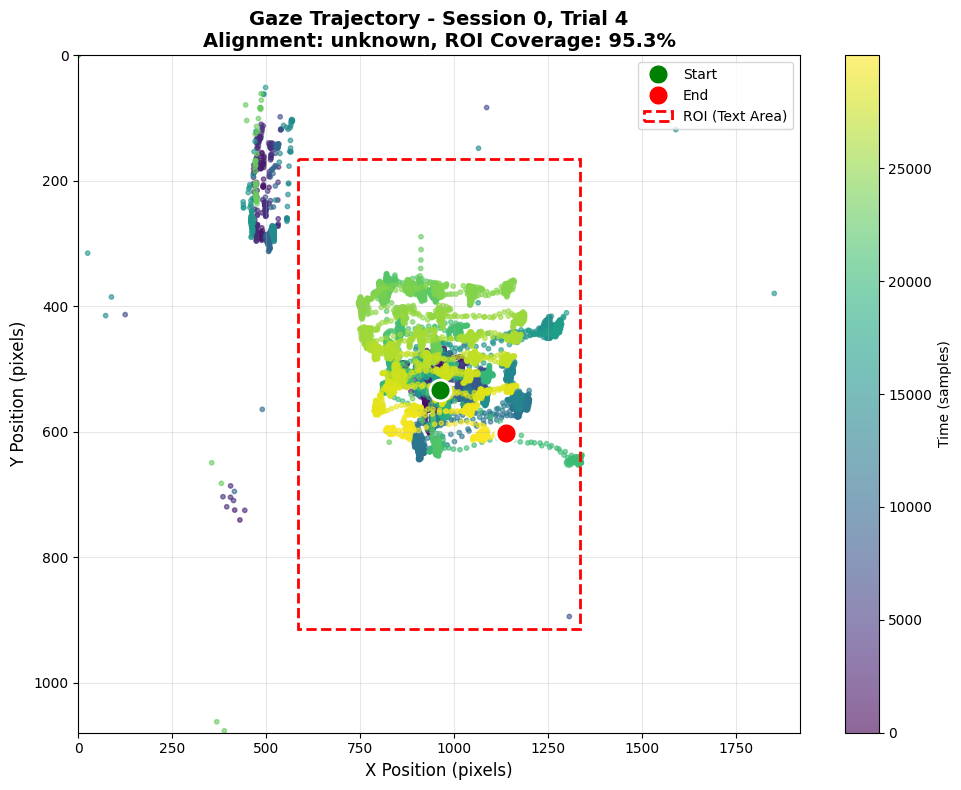

✓ Saved figure to ./figures/gaze_trajectory_example.png


In [31]:
# Visualize first trial from Session 0
if 0 in all_sessions_data and len(all_sessions_data[0]) > 0:
    trial = all_sessions_data[0][0]
    fig, ax = plot_trial_gaze(trial)
    plt.savefig('./figures/gaze_trajectory_example.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved figure to ./figures/gaze_trajectory_example.png')
else:
    print('No trial data available')

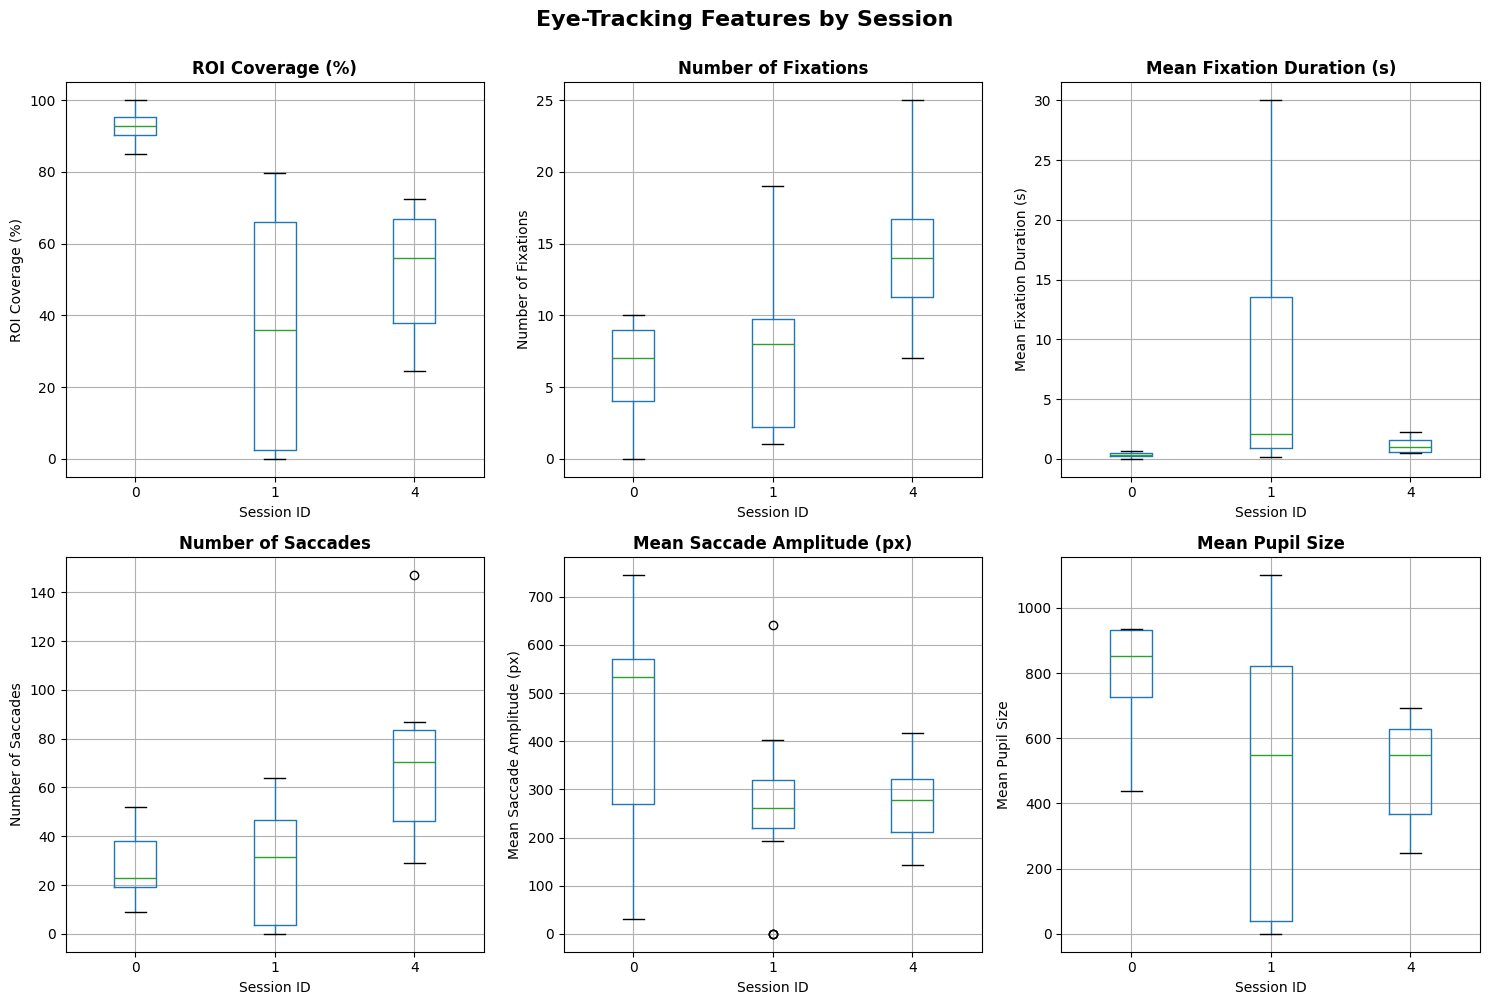

✓ Saved figure to ./figures/eye_tracking_features_by_session.png


In [32]:
# Plot feature distributions across sessions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features_to_plot = [
    ('roi_coverage', 'ROI Coverage (%)'),
    ('fixation_count', 'Number of Fixations'),
    ('fixation_duration_mean', 'Mean Fixation Duration (s)'),
    ('saccade_count', 'Number of Saccades'),
    ('saccade_amplitude_mean', 'Mean Saccade Amplitude (px)'),
    ('pupil_size_mean', 'Mean Pupil Size')
]

for idx, (feature, label) in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Box plot by session
    df_features.boxplot(column=feature, by='session_id', ax=ax)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xlabel('Session ID', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.get_figure().suptitle('')  # Remove default title
    
plt.suptitle('Eye-Tracking Features by Session', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('./figures/eye_tracking_features_by_session.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved figure to ./figures/eye_tracking_features_by_session.png')